In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter


from sqlalchemy import create_engine, text

#maximum number of rows to display
pd.options.display.max_rows = 20
DB_USERNAME = ''
DB_PASSWORD = ''
DB_HOST = ' '
DB_PORT= ''
DB_NAME = ''
engine=create_engine(f'postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}', max_overflow=20, client_encoding='utf8')

def runQuery(sql):
    result = engine.connect().execution_options(isolation_level="AUTOCOMMIT").execute((text(sql)))
    return pd.DataFrame(result.fetchall(), columns=result.keys())

In [2]:
query1="""
select codenc, telelink, fecha, duracion, edad,  "ciudad", "estrato", edcc.etiqueta as "genero" from (
select codenc, telelink, fecha, duracion, edad, "cod_ciudad", "ciudad", estrato as "cod_estrato", 
edcc.etiqueta as "estrato", genero from(
select codenc, telelink, fecha, duracion, edad, ciudad as "cod_ciudad", edcc.etiqueta as "ciudad", estrato, genero
from ecar_dwh.ecar_dwh_base_encuestas_efectivas edbee 
inner join ecar_dwh.ecar_dwh_base_correspondencia_codigos edcc on edbee.ciudad=edcc.codigo
where edcc.campo='ciudad')tt
inner join ecar_dwh.ecar_dwh_base_correspondencia_codigos edcc on tt.estrato=edcc.codigo
where edcc.campo='estrato')tt1
inner join ecar_dwh.ecar_dwh_base_correspondencia_codigos edcc on tt1.genero=edcc.codigo
where edcc.campo='genero'
"""
df=runQuery(query1)

In [3]:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce').dt.strftime('%Y-%m-%d')
df['ciudad']=df['ciudad'].astype('category')
df['estrato']=df['estrato'].astype('category')
#df['week'] = df['fecha'].dt.week
#df['month'] = df['fecha'].dt.month
#df['day'] = df['fecha'].dt.day

In [4]:
df

,codenc,telelink,fecha,duracion,edad,ciudad,estrato,genero
0,Encuestador 280,163503.0,2017-10-06,618,15,Bogotá,Medio Bajo,Hombre
1,Encuestador 84,163505.0,2017-10-06,901,25,Bogotá,Bajo,Hombre
2,Encuestador 223,163508.0,2017-10-06,478,12,Bogotá,Bajo,Hombre
3,Encuestador 282,163510.0,2017-10-06,412,35,Bogotá,Bajo,Mujer
4,Encuestador 116,163512.0,2017-10-06,812,28,Bogotá,Bajo,Hombre
...,...,...,...,...,...,...,...,...
142256,Encuestador 135,155628.0,2017-08-31,608,38,Bogotá,Medio Alto,Hombre
142257,Encuestador 95,155629.0,2017-08-31,1011,35,Bogotá,Medio Alto,Hombre
142258,Encuestador 100,155630.0,2017-08-31,453,16,Bogotá,Medio Bajo,Hombre
142259,Encuestador 292,155631.0,2017-08-31,894,37,Bogotá,Alto,Mujer


In [5]:
fg=df.copy()
fg

,codenc,telelink,fecha,duracion,edad,ciudad,estrato,genero
0,Encuestador 280,163503.0,2017-10-06,618,15,Bogotá,Medio Bajo,Hombre
1,Encuestador 84,163505.0,2017-10-06,901,25,Bogotá,Bajo,Hombre
2,Encuestador 223,163508.0,2017-10-06,478,12,Bogotá,Bajo,Hombre
3,Encuestador 282,163510.0,2017-10-06,412,35,Bogotá,Bajo,Mujer
4,Encuestador 116,163512.0,2017-10-06,812,28,Bogotá,Bajo,Hombre
...,...,...,...,...,...,...,...,...
142256,Encuestador 135,155628.0,2017-08-31,608,38,Bogotá,Medio Alto,Hombre
142257,Encuestador 95,155629.0,2017-08-31,1011,35,Bogotá,Medio Alto,Hombre
142258,Encuestador 100,155630.0,2017-08-31,453,16,Bogotá,Medio Bajo,Hombre
142259,Encuestador 292,155631.0,2017-08-31,894,37,Bogotá,Alto,Mujer


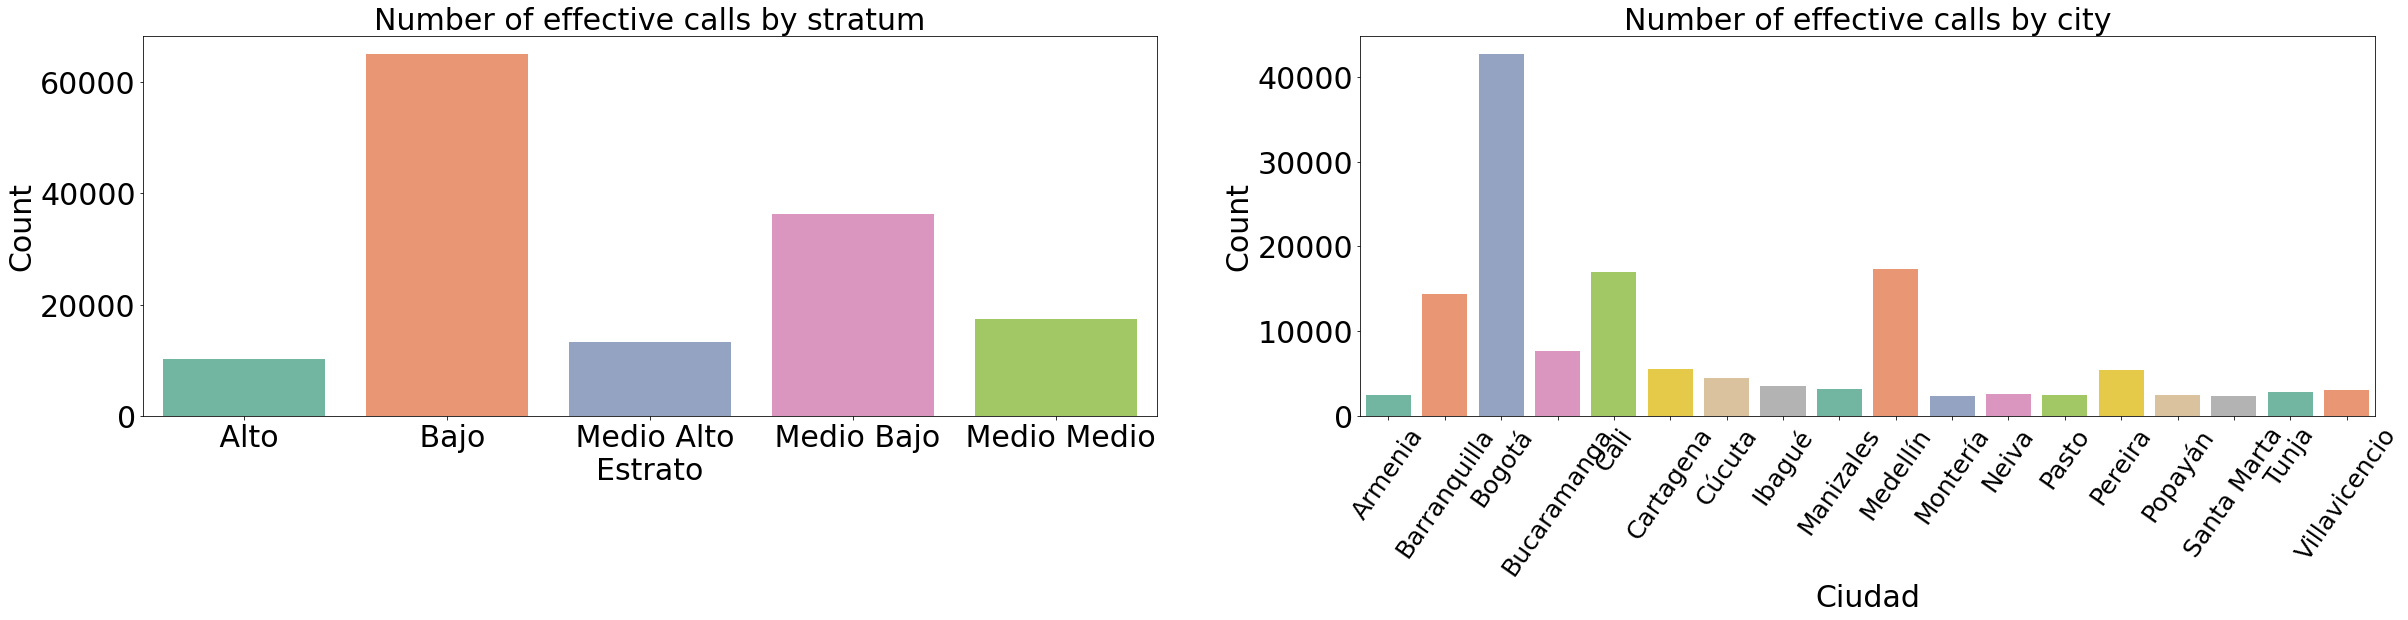

In [6]:
df_count=df.groupby('estrato')[['codenc']].count().rename(columns={'codenc':"count"})
df_count1=df.groupby('ciudad')[['codenc']].count().rename(columns={'codenc':"count"})
df_count2=df.groupby(['ciudad', 'estrato'])[['codenc']].count().rename(columns={'codenc':"count"}).reset_index()
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(40, 7))
sns.barplot(x=df_count.index, y='count', data=df_count, ax=ax[0], palette='Set2')
sns.barplot(x=df_count1.index, y='count', data=df_count1, ax=ax[1], palette='Set2')
ax[0].set_title('Number of effective calls by stratum', fontsize=30)
ax[1].set_title('Number of effective calls by city',fontsize=30)
ax[0].tick_params(axis="x", labelsize=30)
ax[0].tick_params(axis="y", labelsize=30)
ax[1].tick_params(axis="x", rotation=55, labelsize=25)
ax[1].tick_params(axis="y", labelsize=30)
ax[0].set_xlabel("Estrato",fontsize=30)
ax[0].set_ylabel("Count",fontsize=30)
ax[1].set_xlabel("Ciudad",fontsize=30)
ax[1].set_ylabel("Count",fontsize=30)
#plt.savefig('llamadas_efectivas_estrato_ciudad.png')

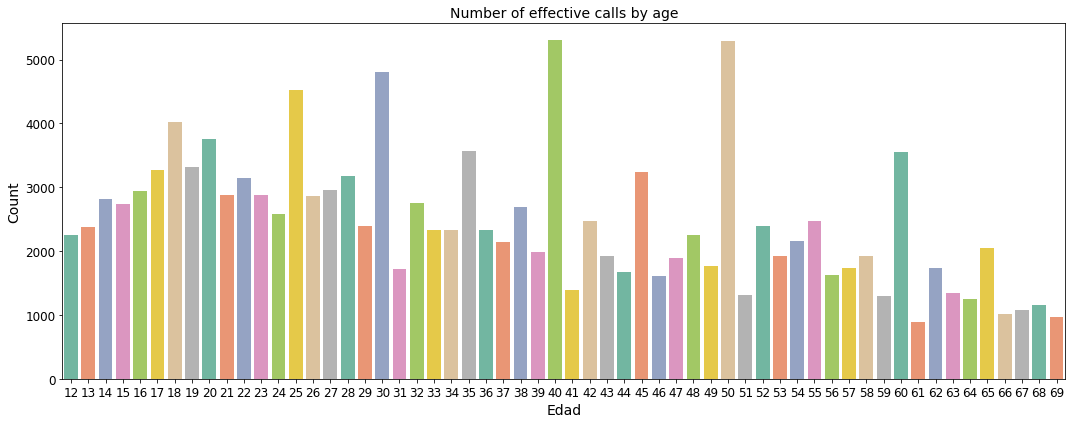

In [7]:
dt=df.groupby('edad')[['codenc']].count().rename(columns={'codenc':"count"})
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=dt.index, y='count', data=dt, palette='Set2')
ax.set_title('Number of effective calls by age', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xlabel("Edad",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
plt.tight_layout()
#plt.savefig('llamadas_efectivas_edad.png')

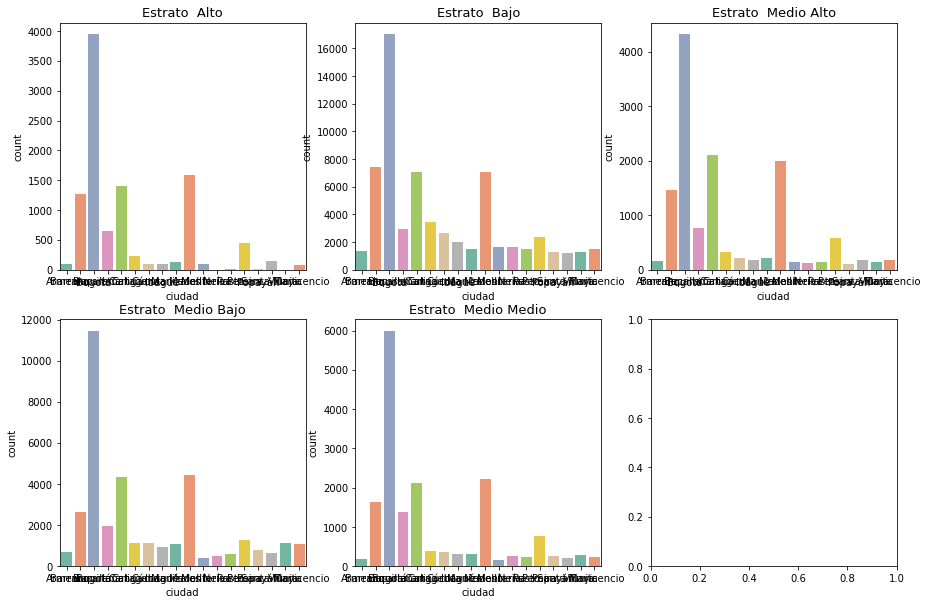

In [8]:
df_count2=df.groupby(['ciudad', 'estrato'])[['codenc']].count().rename(columns={'codenc':"count"}).reset_index()
fig, ax = plt.subplots(ncols=3, nrows=2,figsize=(15,10))
for estr, axis in zip(df_count2['estrato'].unique(), ax.flatten()):        
    ax_ = sns.barplot(x="ciudad", y='count',
                       data=df_count2[df_count2['estrato']==estr], palette="Set2",
                       ax=axis)
    axis.set_title('Estrato '+str(estr), fontsize=13)
    #plt.savefig('llamadas_efectivas_por_estrato y ciudad.png')

In [9]:
df[['duracion']].describe()

,duracion
count,142261.000000
mean,805.829785
std,423.994722
min,-252.000000
25%,555.000000
50%,733.000000
75%,963.000000
max,17492.000000


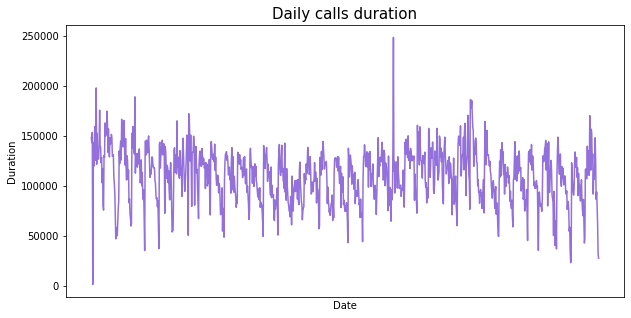

In [10]:
df_diarios=df.groupby('fecha').agg({'duracion':"sum"}).reset_index()
df_diarios


fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='fecha',y='duracion', data=df_diarios, color='mediumpurple')
ax.xaxis.set_major_locator(MonthLocator())
ax.tick_params(axis="x",  labelrotation=45)
ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
ax.set_xlabel("Date",fontsize=10)
ax.set_ylabel("Duration",fontsize=10)
ax.set_title('Daily calls duration', size=15)
ax.autoscale_view(scalex=True)
#plt.savefig('Daily calls duration1.png')

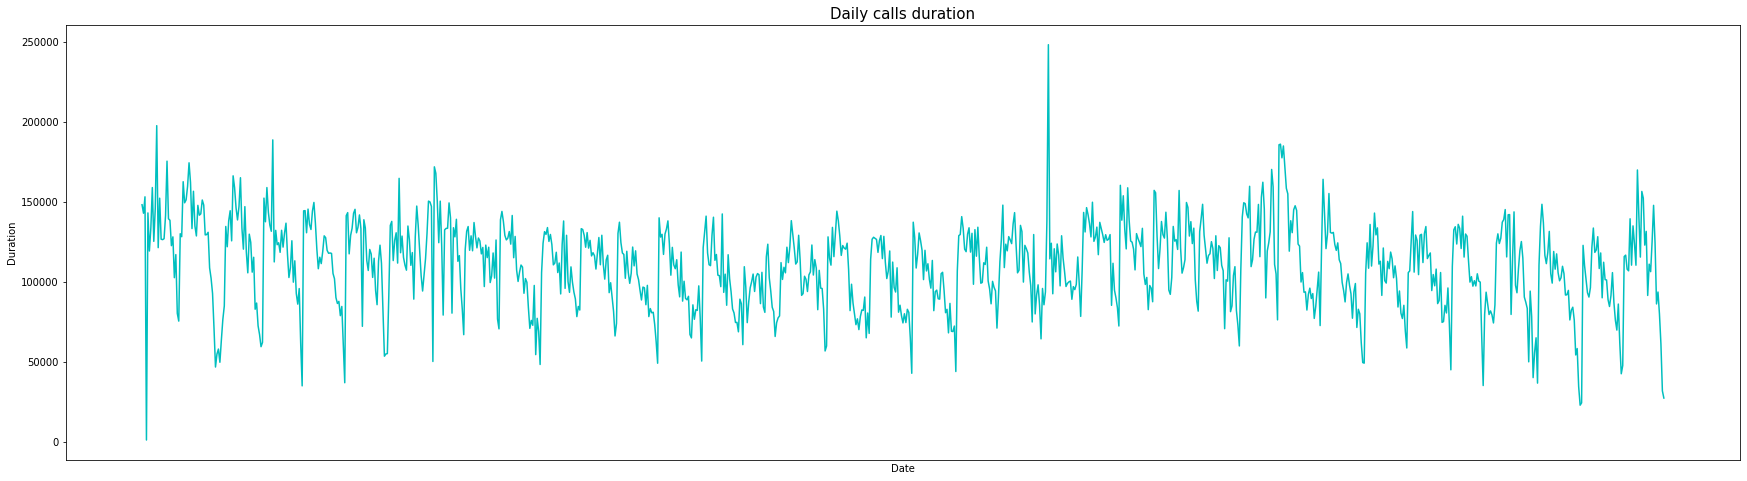

In [11]:

from matplotlib.dates import WeekdayLocator, DateFormatter
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,8))
sns.lineplot(x='fecha',y='duracion', data=df_diarios, color='c')
ax.set_title('Daily calls duration', size=15)
ax.xaxis.set_major_locator(WeekdayLocator())
ax.tick_params(axis="x",  labelrotation=90)
ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
ax.set_xlabel("Date",fontsize=10)
ax.set_ylabel("Duration",fontsize=10)
ax.autoscale_view(scalex=True)
#plt.savefig('Daily calls duration2.png')

In [12]:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['week'] = df['fecha'].dt.week
df['weekdays'] = df['fecha'].dt.weekday
df['days'] = df['fecha'].dt.day

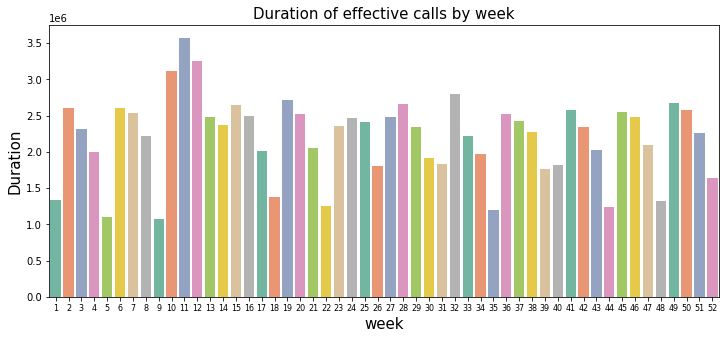

In [13]:
dff=df.groupby(['week']).agg({'duracion':"sum"}).reset_index()

fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='week', y='duracion', data=dff, palette='Set2')
ax.set_xlabel("week",fontsize=15)
ax.set_ylabel("Duration",fontsize=15)
ax.set_title('Duration of effective calls by week',fontsize=15)
ax.tick_params(axis="x", labelsize=8)
#plt.savefig('Duration of effective calls by week.png')

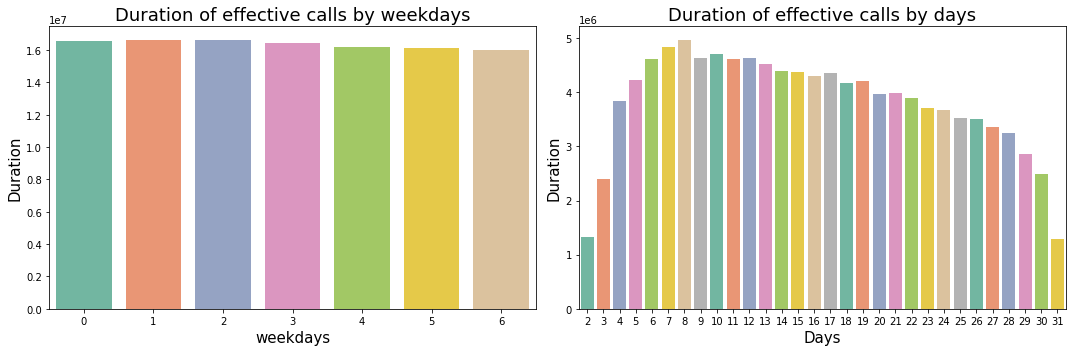

In [14]:
dff=df.groupby(['weekdays']).agg({'duracion':"sum"}).reset_index()
dff1=df.groupby(['days']).agg({'duracion':"sum"}).reset_index()



fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15, 5))
sns.barplot(x='weekdays', y='duracion', data=dff, palette="Set2",ax=ax[0])
sns.barplot(x='days', y='duracion', data=dff1, palette="Set2",  ax=ax[1])

ax[0].set_title('Duration of effective calls by weekdays', fontsize=18)
ax[1].set_title('Duration of effective calls by days',fontsize=18)
ax[0].tick_params(axis="x", labelsize=10)
ax[0].tick_params(axis="y", labelsize=10)
ax[1].tick_params(axis="x", labelsize=10)
ax[1].tick_params(axis="y", labelsize=10)
ax[0].set_xlabel("weekdays",fontsize=15)
ax[0].set_ylabel("Duration",fontsize=15)
ax[1].set_xlabel("Days",fontsize=15)
ax[1].set_ylabel("Duration",fontsize=15)
#plt.savefig('Duration of effective calls by days and weekdays.png')
plt.tight_layout()

In [15]:
len(df['fecha'].unique())

1037

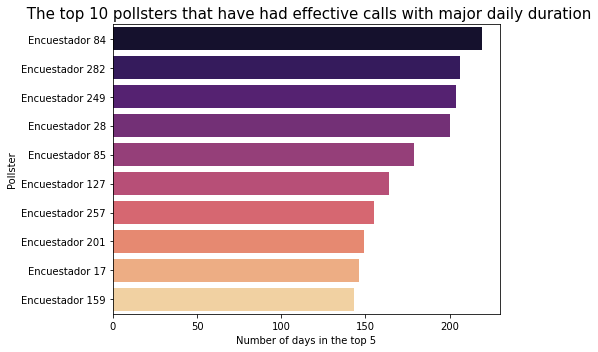

In [16]:
dt=df.groupby(['fecha', 'codenc']).agg({'duracion':"sum"}).reset_index().sort_values('duracion', ascending=False).sort_values('fecha')
dt1=dt.groupby('fecha').head(10)
df_count=dt1.groupby('codenc')[['fecha']].count().reset_index().rename(columns={'fecha':'count'}).sort_values('count', ascending=False)
fig, ax = plt.subplots(ncols=1,figsize=(8,5))
sns.barplot(x='count', y='codenc', data=df_count.head(10), palette='magma')
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_ylabel("Pollster",fontsize=10)
ax.set_xlabel("Number of days in the top 5",fontsize=10)
ax.set_title(' The top 10 pollsters that have had effective calls with major daily duration', fontsize=15, loc='center')
plt.tight_layout()

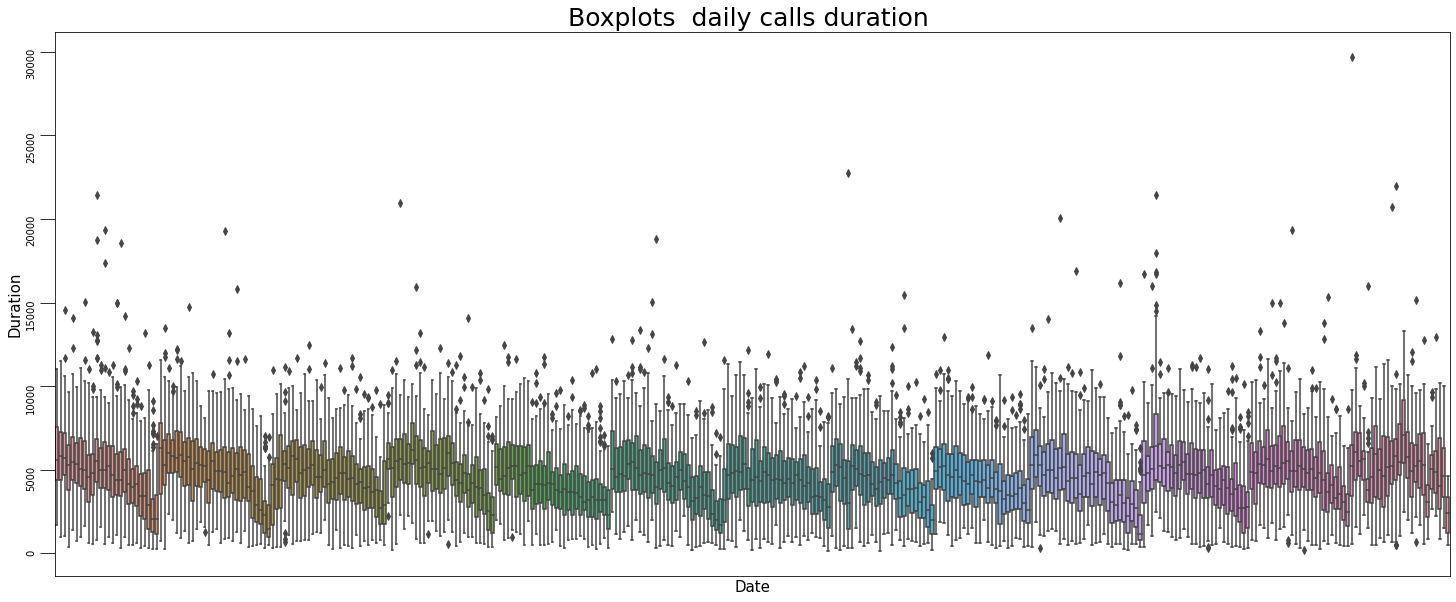

In [17]:

datos=df.groupby(['fecha', 'codenc']).agg({'duracion':"sum"}).reset_index()
datos['fecha']=datos['fecha'].dt.strftime('%b %d')
fig, ax = plt.subplots(figsize=(25,10))
sns.boxplot(x="fecha", y='duracion', data=datos)
ax.set_title('Boxplots  daily calls duration ', size=25)
ax.xaxis.set_major_locator(WeekdayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b %d"))
ax.tick_params(axis="x",  labelrotation=90, size=5)
ax.tick_params(axis="y",  labelrotation=90, size=15)
ax.set_xlabel("Date",fontsize=15)
ax.set_ylabel("Duration",fontsize=15)
ax.autoscale_view(scalex=True)
#plt.savefig('Boxplots daily calls duration.png')

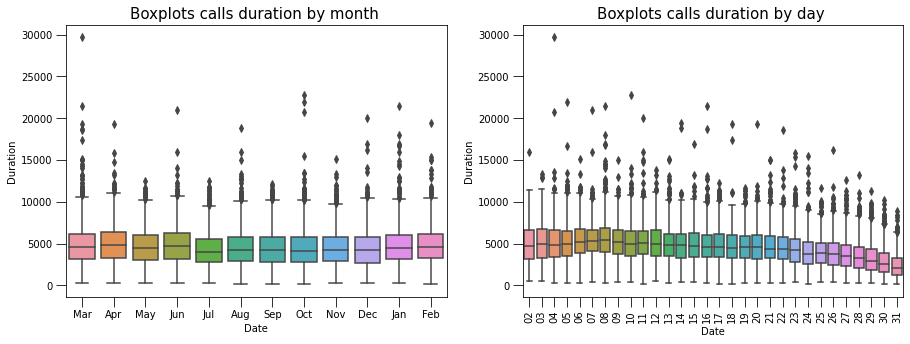

In [18]:

datos=df.groupby(['fecha', 'codenc']).agg({'duracion':"sum"}).reset_index()
datos2=df.groupby(['fecha', 'codenc']).agg({'duracion':"sum"}).reset_index()
datos['fecha']=datos['fecha'].dt.strftime('%d')
datos2['fecha']=datos2['fecha'].dt.strftime('%b')
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15, 5))
sns.boxplot(x="fecha", y='duracion', data=datos2, ax=ax[0])
sns.boxplot(x="fecha", y='duracion', data=datos, ax=ax[1])
ax[0].set_title('Boxplots calls duration by month ', size=15)
ax[0].tick_params(axis="x", size=10)
ax[0].tick_params(axis="y", size=10)
ax[0].set_xlabel("Date",fontsize=10)
ax[0].set_ylabel("Duration",fontsize=10)
ax[0].autoscale_view(scalex=True)
ax[1].set_title('Boxplots calls duration by day ', size=15)
ax[1].tick_params(axis="x",  labelrotation=90, size=10)
ax[1].tick_params(axis="y", size=10)
ax[1].set_xlabel("Date",fontsize=10)
ax[1].set_ylabel("Duration",fontsize=10)
ax[1].autoscale_view(scalex=True)
#plt.savefig('Boxplots calls duration by month and day.png')